In [1]:
# 导入需要的包
import networkx as nx

from networkx.generators.community import LFR_benchmark_graph

import matplotlib
import matplotlib.pyplot as plt

from pyspark.ml.clustering import KMeans

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors


from sklearn.metrics import normalized_mutual_info_score
from clusim.clustering import Clustering
import clusim.sim as sim

In [2]:
###
# 导入 networkx 包并给定参数生成 LFR 图
# import networkx as nx

# from networkx.generators.community import LFR_benchmark_graph
n = 1000
tau1 = 2  # Power-law exponent for the degree distribution
tau2 = 1.1 # Power-law exponent for the community size distribution 
            #S hould be >1
mu = 0.1 # Mixing parameter

G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=25, max_degree=100, min_community=50, max_community=100, 
    seed=2
)

# nx.draw(G, pos=nx.spring_layout(G),node_color='r', node_size=3, edge_color='b')  # Draw the graph generated above

In [3]:
G = nx.Graph(G) # Remove multi-edges

selfloop_edges = list(nx.selfloop_edges(G)) # a list of self loops

G.remove_edges_from(selfloop_edges) # Remove self-loops

In [4]:
# LFR 图是有内在的社群结构的，每个节点的社群存储在其 community 属性中，是一个 set
# 通过运行循环，按照内在的社群结构给每个节点一个标签 即为其 intrinsic_membership
# 为了方便 intrinsic_membership 一开始是作为一个 dict 存储的，后来将其转化为一个 list
intrinsic_communities = {frozenset(G.nodes[v]["community"]) for v in G}
intrinsic_membership = {}
for node in range(G.number_of_nodes()):
    for index, inner_set in enumerate(intrinsic_communities):
        if node in inner_set:
            intrinsic_membership[node] = index
            break
# intrinsic_membership = list(intrinsic_membership.values())
# Print the labels
# for number, label in membership.items():
# print(f"Number {number} belongs to {label}")

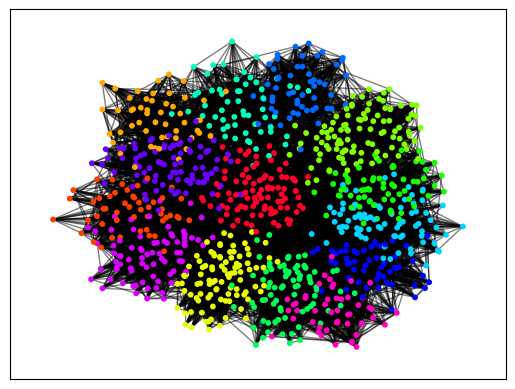

In [5]:
# 对于每个节点，按照其 intrinsic_membership 着色画图
#import matplotlib
#import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,
                      pos,
                      #intrinsic_membership.keys(),
                      node_size=10,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(intrinsic_membership.values())
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

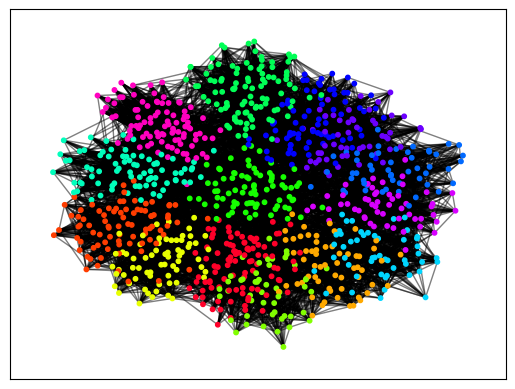

In [6]:
# 利用 Louvain 算法进行社群识别并画图
# louvain_membership 一开始是作为一个 dict 给出的，后来将其转化为一个 list
from community import community_louvain
# import matplotlib
# import matplotlib.pyplot as plt


louvain_membership = community_louvain.best_partition(G)

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,
                      pos,
                      #louvain_membership.keys(),
                      node_size=10,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(louvain_membership.values())
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [7]:
print(f"The network has {max(intrinsic_membership.values())+1} intrinsic communities.")
print(f"Louvain algorithm gives {max(louvain_membership.values())+1} communities.")

The network has 14 intrinsic communities.
Louvain algorithm gives 14 communities.


In [8]:
# 计算 
# 内在的社群结构 intrinsic_membership 和
# Louvain 算法给出的 louvain_membership 
# 的 NMI
# from sklearn.metrics import normalized_mutual_info_score

# Calculate the NMI
nmi = normalized_mutual_info_score(list(louvain_membership.values()), list(intrinsic_membership.values()))

print("NMI:", nmi)


NMI: 1.0


In [9]:
# 计算 
# 内在的社群结构 intrinsic_membership 和
# Louvain 算法给出的 louvain_membership 
# 的 Element centric similarity
# from clusim.clustering import Clustering
# import clusim.sim as sim


intrinsic_clustering = Clustering(elm2clu_dict={i: [intrinsic_membership[i]] for i in intrinsic_membership.keys()})
louvain_clustering = Clustering(elm2clu_dict={i: [louvain_membership[i]] for i in louvain_membership.keys()})

similarity = sim.element_sim(intrinsic_clustering, louvain_clustering, alpha=0.9)

print(similarity)

1.0


In [10]:
from gem.embedding.hope import HOPE
hope_model = HOPE(d=20, beta=0.01) 
# A higher value of beta places more emphasis on capturing higher-order proximities

hope_embd = hope_model.learn_embedding(graph=G, is_weighted=True, no_python=True)

### HOPE 方法结果
hope_embd[:2]

SVD error (low rank): 1.495171


array([[-0.00441854,  0.00104812, -0.00474567, -0.00312658, -0.00878611,
         0.0022295 , -0.00729872, -0.029722  , -0.11969625,  0.09821556,
        -0.00441854,  0.00104812, -0.00474567, -0.00312658, -0.00878611,
         0.0022295 , -0.00729872, -0.029722  , -0.11969625,  0.09821556],
       [-0.00531   ,  0.00571705, -0.01024085,  0.00015931, -0.02539707,
        -0.08010452,  0.08019729,  0.05894209, -0.00322558,  0.01948061,
        -0.00531   ,  0.00571705, -0.01024085,  0.00015931, -0.02539707,
        -0.08010452,  0.08019729,  0.05894209, -0.00322558,  0.01948061]])

In [11]:
# Create a Spark DataFrame from the points

# from pyspark.sql import SparkSession
# from pyspark.ml.linalg import Vectors

#hope_spark = SparkSession.builder.getOrCreate()

hope_vec = [Vectors.dense(row) for row in hope_embd]
hope_prep = SparkSession.builder.getOrCreate().\
                        createDataFrame([(vector,) for vector in hope_vec], ["embd"])

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/24 22:09:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/24 22:09:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/06/24 22:09:12 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [12]:
# from pyspark.ml.clustering import KMeans

# Create and fit the KMeans model
euclid_kmeans = KMeans(k=14, featuresCol="embd")
cosine_kmeans = KMeans(k=14, featuresCol="embd", distanceMeasure="cosine")
hope_euclid_model = euclid_kmeans.fit(hope_prep)
hope_cosine_model = cosine_kmeans.fit(hope_prep)

23/06/24 22:09:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [13]:
# Add the cluster assignment to the DataFrame
hope_euclid = hope_euclid_model.transform(hope_prep)
hope_cosine = hope_cosine_model.transform(hope_prep)


# hope_euclid.show(truncate=False) # 这条语句可以查看 

# Extract the cluster assignment and convert it to a list
hope_euclid_membership = hope_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
hope_cosine_membership = hope_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

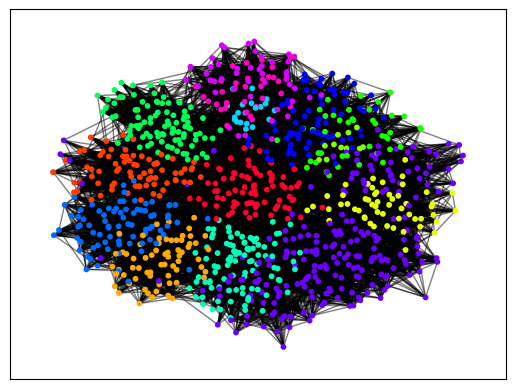

In [14]:
nx.draw_networkx_nodes(G,
                      pos,
                      #louvain_membership.keys(),
                      node_size=10,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(hope_euclid_membership)
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

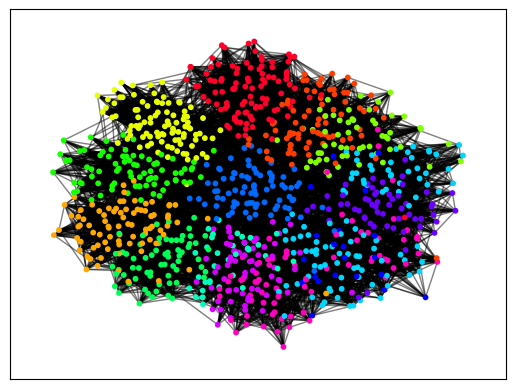

In [15]:
nx.draw_networkx_nodes(G,
                      pos,
                      #louvain_membership.keys(),
                      node_size=10,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=list(hope_cosine_membership)
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [16]:
# 计算 
# 内在的社群结构 intrinsic_membership 和
# 嵌入聚类算法 
# 的 NMI 以及 Element centric similarity
# from sklearn.metrics import normalized_mutual_info_score

# Calculate the NMI
hope_euclid_nmi = normalized_mutual_info_score(list(hope_euclid_membership), list(intrinsic_membership.values()))
hope_cosine_nmi = normalized_mutual_info_score(list(hope_cosine_membership), list(intrinsic_membership.values()))

print("NMIs:", hope_euclid_nmi, hope_cosine_nmi)

hope_euclid_clustering = Clustering(elm2clu_dict={i: [hope_euclid_membership[i]] for i in range(len(hope_euclid_membership))})
hope_cosine_clustering = Clustering(elm2clu_dict={i: [hope_cosine_membership[i]] for i in range(len(hope_cosine_membership))})

hope_euclid_similarity = sim.element_sim(intrinsic_clustering, hope_euclid_clustering, alpha=0.9)
hope_cosine_similarity = sim.element_sim(intrinsic_clustering, hope_cosine_clustering, alpha=0.9)

print("ECSim:", hope_euclid_similarity, hope_cosine_similarity)

NMIs: 0.8944379163000394 0.9129748353457429
ECSim: 0.7371636375570219 0.8179755384469528


In [17]:
### Laplacian 方法
from gem.embedding.lap import LaplacianEigenmaps
lap_model = LaplacianEigenmaps(d=20)

lap_embd = lap_model.learn_embedding(graph=G, is_weighted=True, no_python=True)

### 输出Laplacian 方法结果
lap_embd[:2]

Laplacian matrix recon. error (low rank): 32.008098


<class 'networkx.utils.decorators.argmap'> compilation 24:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


array([[ 0.0550313 , -0.11689289,  0.02381229, -0.013658  ,  0.02293694,
         0.02933027, -0.02233078, -0.00477909,  0.01174754,  0.0325324 ,
         0.00456699, -0.00700094, -0.00072924,  0.01170239, -0.00351187,
         0.00203275,  0.00217483,  0.01224879, -0.01152034,  0.00841999],
       [ 0.03160855,  0.05535647, -0.02316193, -0.11208287, -0.02725976,
         0.00132852, -0.00394549, -0.03030306,  0.01364658,  0.02910149,
        -0.00733802, -0.00811729, -0.00594692, -0.01166885, -0.01781334,
         0.00851181, -0.03210159, -0.03409561, -0.04254487,  0.01606568]])

In [18]:
# Create a Spark DataFrame from the points

# from pyspark.sql import SparkSession
# from pyspark.ml.linalg import Vectors

#hope_spark = SparkSession.builder.getOrCreate()

lap_vec = [Vectors.dense(row) for row in lap_embd]
lap_prep = SparkSession.builder.getOrCreate().\
                        createDataFrame([(vector,) for vector in lap_vec], ["embd"])

In [19]:
# from pyspark.ml.clustering import KMeans

# Create and fit the KMeans model
euclid_kmeans = KMeans(k=14, featuresCol="embd")
cosine_kmeans = KMeans(k=14, featuresCol="embd", distanceMeasure="cosine")
lap_euclid_model = euclid_kmeans.fit(lap_prep)
lap_cosine_model = cosine_kmeans.fit(lap_prep)

In [20]:
# Add the cluster assignment to the DataFrame
lap_euclid = lap_euclid_model.transform(lap_prep)
lap_cosine = lap_cosine_model.transform(lap_prep)


# hope_euclid.show(truncate=False) # 这条语句可以查看 

# Extract the cluster assignment and convert it to a list
lap_euclid_membership = lap_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
lap_cosine_membership = lap_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

In [21]:
# 计算 
# 内在的社群结构 intrinsic_membership 和
# 嵌入聚类算法 
# 的 NMI 以及 Element centric similarity
# from sklearn.metrics import normalized_mutual_info_score

# Calculate the NMI
lap_euclid_nmi = normalized_mutual_info_score(list(lap_euclid_membership), list(intrinsic_membership.values()))
lap_cosine_nmi = normalized_mutual_info_score(list(lap_cosine_membership), list(intrinsic_membership.values()))

print("NMIs:", lap_euclid_nmi, lap_cosine_nmi)

lap_euclid_clustering = Clustering(elm2clu_dict={i: [lap_euclid_membership[i]] for i in range(len(lap_euclid_membership))})
lap_cosine_clustering = Clustering(elm2clu_dict={i: [lap_cosine_membership[i]] for i in range(len(lap_cosine_membership))})

lap_euclid_similarity = sim.element_sim(intrinsic_clustering, lap_euclid_clustering, alpha=0.9)
lap_cosine_similarity = sim.element_sim(intrinsic_clustering, lap_cosine_clustering, alpha=0.9)

print("ECSim:", lap_euclid_similarity, lap_cosine_similarity)

NMIs: 0.9320318032515845 0.960566987508249
ECSim: 0.7769195458629421 0.853515359783401


In [22]:
### Locally Linear 方法
from gem.embedding.lle import LocallyLinearEmbedding

lle_model = LocallyLinearEmbedding(d=40)

lle_embd = lle_model.learn_embedding(graph=G, is_weighted=True, no_python=True)
### 输出 Locally Linear 方法结果
lle_embd[:2]


array([[-0.00209393,  0.01668918, -0.01038232, -0.01580422,  0.01722309,
         0.00622091, -0.03284193, -0.02142366,  0.00309434, -0.00983615,
         0.02634845, -0.00152013,  0.01069142, -0.02509144,  0.00822382,
         0.02064817,  0.01324615,  0.02225601,  0.01335126, -0.05274727,
        -0.01118699, -0.000942  , -0.00059518,  0.00526201, -0.01391324,
        -0.03993982, -0.01591574, -0.01171471,  0.01264003,  0.01647367,
         0.00670759, -0.0049729 ,  0.00945857,  0.02591875,  0.01655464,
        -0.00709092, -0.01806272,  0.00813136,  0.00548305, -0.00713852],
       [-0.01727363, -0.01207299,  0.02513854, -0.00525122, -0.00429838,
         0.02272431,  0.01258938, -0.01641499,  0.00985196,  0.0264179 ,
         0.02035466, -0.02183222,  0.0238176 , -0.03237401, -0.00150991,
         0.00338641, -0.00616131,  0.00790083,  0.00983901,  0.01644295,
         0.00954549,  0.03989076, -0.00506426, -0.07243674,  0.0068966 ,
        -0.02033779, -0.01713749, -0.00964794,  0.

In [23]:
# Create a Spark DataFrame from the points

# from pyspark.sql import SparkSession
# from pyspark.ml.linalg import Vectors

#hope_spark = SparkSession.builder.getOrCreate()

lle_vec = [Vectors.dense(row) for row in lle_embd]
lle_prep = SparkSession.builder.getOrCreate().\
                        createDataFrame([(vector,) for vector in lle_vec], ["embd"])

In [24]:
# from pyspark.ml.clustering import KMeans

# Create and fit the KMeans model
euclid_kmeans = KMeans(k=14, featuresCol="embd")
cosine_kmeans = KMeans(k=14, featuresCol="embd", distanceMeasure="cosine")
lle_euclid_model = euclid_kmeans.fit(lle_prep)
lle_cosine_model = cosine_kmeans.fit(lle_prep)

In [25]:
# Add the cluster assignment to the DataFrame
lle_euclid = lle_euclid_model.transform(lle_prep)
lle_cosine = lle_cosine_model.transform(lle_prep)


# hope_euclid.show(truncate=False) # 这条语句可以查看 

# Extract the cluster assignment and convert it to a list
lle_euclid_membership = lle_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
lle_cosine_membership = lle_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

In [26]:
# 计算 
# 内在的社群结构 intrinsic_membership 和
# 嵌入聚类算法 
# 的 NMI 以及 Element centric similarity
# from sklearn.metrics import normalized_mutual_info_score

# Calculate the NMI
lle_euclid_nmi = normalized_mutual_info_score(list(lle_euclid_membership), list(intrinsic_membership.values()))
lle_cosine_nmi = normalized_mutual_info_score(list(lle_cosine_membership), list(intrinsic_membership.values()))

print("NMIs:", lle_euclid_nmi, lle_cosine_nmi)

lle_euclid_clustering = Clustering(elm2clu_dict={i: [lle_euclid_membership[i]] for i in range(len(lle_euclid_membership))})
lle_cosine_clustering = Clustering(elm2clu_dict={i: [lle_cosine_membership[i]] for i in range(len(lle_cosine_membership))})

lle_euclid_similarity = sim.element_sim(intrinsic_clustering, lle_euclid_clustering, alpha=0.9)
lle_cosine_similarity = sim.element_sim(intrinsic_clustering, lle_cosine_clustering, alpha=0.9)

print("ECSim:", lle_euclid_similarity, lle_cosine_similarity)

NMIs: 0.053153314473176436 0.04592253534786921
ECSim: 0.08007076496687068 0.07971537175755168


In [27]:
### Node2Vec 方法  This implementation in GEM package is too slow!!!
from gem.embedding.node2vec import node2vec
n2v_model = node2vec(d=64, max_iter=10, walk_len=30, num_walks=200, con_size=10, ret_p=1, inout_p=1)

n2v_embd = n2v_model.learn_embedding(graph=G, is_weighted=False, no_python=True)
### 输出 Locally Linear 方法结果
n2v_embd[:2]


An algorithmic framework for representational learning on graphs. [Jun 10 2023]
Input graph path (-i:)=tempGraph.graph
Output graph path (-o:)=tempGraph.emb
Number of dimensions. Default is 128 (-d:)=64
Length of walk per source. Default is 80 (-l:)=30
Number of walks per source. Default is 10 (-r:)=200
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=10
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=YES
Graph is directed. (-dr)=YES
Graph is weighted. (-w)=YES
Output random walks instead of embeddings. (-ow)=NO
Read 16966 lines from tempGraph.graph
Preprocessing progress: 80.00% 
Walking Progress: 5.00%
Learning Progress: 83.40% 


array([[-7.14633e+00, -1.37797e+00, -2.85679e+00,  1.18286e+00,
         3.63500e+00,  2.69562e+00,  2.76734e-01,  2.58938e+00,
         2.60435e-01, -2.21520e-01,  2.78267e-01,  1.26369e+00,
         2.15951e-01, -7.30175e-02,  2.65337e+00,  1.44392e+00,
        -1.88421e+00, -1.07579e+00, -1.53403e-01,  1.05121e+00,
        -1.73301e+00,  1.11243e+00,  1.98051e+00,  7.63787e-02,
         1.60246e-02, -1.11284e-01, -1.24306e-01,  7.61916e-01,
        -1.39407e-01,  1.48375e-01, -1.77907e-01, -5.87977e-02,
        -1.84062e-01, -5.46248e-01,  3.10250e-01, -1.30258e-01,
         2.15490e-01, -2.74283e-02, -3.27146e-01, -5.92437e-02,
        -3.94928e-01, -2.80162e-01,  2.99979e-01, -2.38279e-01,
        -4.24999e-01,  9.87763e-02, -7.15321e-02,  6.42363e-01,
        -1.27142e-01,  8.52266e-01,  1.29309e-01,  8.91306e-02,
         5.18176e-01,  3.98206e+00,  2.36346e-01,  8.97503e-01,
        -4.40102e-01, -2.01971e-01,  5.41682e-01, -2.91077e-02,
        -2.85047e+00, -2.82146e+00,  2.4

In [28]:
# Create a Spark DataFrame from the points

# from pyspark.sql import SparkSession
# from pyspark.ml.linalg import Vectors

#hope_spark = SparkSession.builder.getOrCreate()

n2v_vec = [Vectors.dense(row) for row in n2v_embd]
n2v_prep = SparkSession.builder.getOrCreate().\
                        createDataFrame([(vector,) for vector in n2v_vec], ["embd"])

In [29]:
# from pyspark.ml.clustering import KMeans

# Create and fit the KMeans model
euclid_kmeans = KMeans(k=14, featuresCol="embd")
cosine_kmeans = KMeans(k=14, featuresCol="embd", distanceMeasure="cosine")
n2v_euclid_model = euclid_kmeans.fit(n2v_prep)
n2v_cosine_model = cosine_kmeans.fit(n2v_prep)

In [30]:
# Add the cluster assignment to the DataFrame
n2v_euclid = n2v_euclid_model.transform(n2v_prep)
n2v_cosine = n2v_cosine_model.transform(n2v_prep)


# hope_euclid.show(truncate=False) # 这条语句可以查看 

# Extract the cluster assignment and convert it to a list
n2v_euclid_membership = n2v_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
n2v_cosine_membership = n2v_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

In [31]:
# 计算 
# 内在的社群结构 intrinsic_membership 和
# 嵌入聚类算法 
# 的 NMI 以及 Element centric similarity
# from sklearn.metrics import normalized_mutual_info_score

# Calculate the NMI
n2v_euclid_nmi = normalized_mutual_info_score(list(n2v_euclid_membership), list(intrinsic_membership.values()))
n2v_cosine_nmi = normalized_mutual_info_score(list(n2v_cosine_membership), list(intrinsic_membership.values()))

print("NMIs:", n2v_euclid_nmi, n2v_cosine_nmi)

n2v_euclid_clustering = Clustering(elm2clu_dict={i: [n2v_euclid_membership[i]] for i in range(len(n2v_euclid_membership))})
n2v_cosine_clustering = Clustering(elm2clu_dict={i: [n2v_cosine_membership[i]] for i in range(len(n2v_cosine_membership))})

n2v_euclid_similarity = sim.element_sim(intrinsic_clustering, n2v_euclid_clustering, alpha=0.9)
n2v_cosine_similarity = sim.element_sim(intrinsic_clustering, n2v_cosine_clustering, alpha=0.9)

print("ECSim:", n2v_euclid_similarity, n2v_cosine_similarity)

NMIs: 0.6691306097869052 0.613035449679516
ECSim: 0.4850008630040618 0.4500030164518611


In [32]:
### MNMF 方法

from karateclub import MNMF

# Create an instance of the MNMF model
MNMF_model = MNMF(dimensions = 64, clusters = 14, lambd = 0.2, 
             alpha = 0.05, beta = 0.05, iterations = 100, 
             lower_control = 1e-15, eta = 5.0, seed = 42)

# Fit the model to the graph
MNMF_model.fit(G)

# Obtain the graph embeddings
MNMF_embd = MNMF_model.get_embedding()

/N/u/zfwei/BigRed200/.conda/envs/mm2/lib/python3.10/site-packages/karateclub/community_detection/overlapping/mnmf.py:82: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self._B1 = nx.adjacency_matrix(


In [33]:
D=64
MNMF_vec = [Vectors.dense(row) for row in MNMF_embd]
MNMF_prep = SparkSession.builder.getOrCreate().\
                    createDataFrame([(vector,) for vector in MNMF_vec], ["embd"])

euclid_kmeans = KMeans(k=14, featuresCol="embd")
cosine_kmeans = KMeans(k=14, featuresCol="embd", distanceMeasure="cosine")
MNMF_euclid_model = euclid_kmeans.fit(MNMF_prep)
MNMF_cosine_model = cosine_kmeans.fit(MNMF_prep)

# Add the cluster assignment to the DataFrame
MNMF_euclid = MNMF_euclid_model.transform(MNMF_prep)
MNMF_cosine = MNMF_cosine_model.transform(MNMF_prep)

# Extract the cluster assignment and convert it to a list
MNMF_euclid_membership = MNMF_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
MNMF_cosine_membership = MNMF_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()
print(max(MNMF_euclid_membership)+1, max(MNMF_cosine_membership)+1)

# Calculate the NMI
MNMF_euclid_nmi = normalized_mutual_info_score(list(MNMF_euclid_membership), list(intrinsic_membership.values()))
MNMF_cosine_nmi = normalized_mutual_info_score(list(MNMF_cosine_membership), list(intrinsic_membership.values()))

print(f"{D}-dimensional NMIs:", MNMF_euclid_nmi, MNMF_cosine_nmi)

MNMF_euclid_clustering = Clustering(elm2clu_dict={i: [MNMF_euclid_membership[i]] for i in range(len(MNMF_euclid_membership))})
MNMF_cosine_clustering = Clustering(elm2clu_dict={i: [MNMF_cosine_membership[i]] for i in range(len(MNMF_cosine_membership))})

MNMF_euclid_similarity = sim.element_sim(intrinsic_clustering, MNMF_euclid_clustering, alpha=0.9)
MNMF_cosine_similarity = sim.element_sim(intrinsic_clustering, MNMF_cosine_clustering, alpha=0.9)

print(f"{D}-dimensional ECSim:", MNMF_euclid_similarity, MNMF_cosine_similarity)

14 14
64-dimensional NMIs: 0.9703184173628853 0.9803609975748384
64-dimensional ECSim: 0.909634189904475 0.9349010619010619
